# Investigation of representation drift through reduced model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from aux import r_tile, c_tile, Generic
from disp import set_font_size, set_color, fast_fig

cc = np.concatenate


# PARAMS
N = 1000
M = 200
N_MAX = 200
Q = .1
THT_S = 1
W_MIN = THT_S/50 + .0001
W_MAX = THT_S/4 + .0001

T_THT = 4
A_THT = 1

I_STD_0 = .375  # BASELINE NOISE
I_STD_1 = .8  # REACTIVATION NOISE

# PLASTICITY
A_P = .05
A_M = -.03
T_P = 3
T_M = 5
T_STDP_MAX = 5*max(T_P, T_M)

# STDP HELPER VARS
T_STDP_P = np.arange(T_STDP_MAX, dtype=int)
T_STDP_M = np.arange(-T_STDP_MAX, -1, dtype=int)
D_W_S_P = A_P*np.exp(-T_STDP_P/T_P)
D_W_S_M = A_M*np.exp(T_STDP_M/T_M)

Run smln

In [2]:
class BinarySTDPNtwk(object):
    """Network of binary spiking neurons."""
    
    def __init__(self, w_0, tht_s, t_tht, a_tht, n_max, t_stdp, d_w_s, w_min, w_max):
        self.w_0 = w_0
        self.tht_s = tht_s
        self.t_tht = t_tht
        self.a_tht = a_tht
        self.n_max = n_max
        self.t_stdp = t_stdp
        self.d_w_s = d_w_s
        self.w_min = w_min
        self.w_max = w_max
        
        self.n = w_0.shape[0]
        
        self.t_stdp_max = t_stdp[-1] + 1
        self.t_stdp_min = t_stdp[0]
        
        self.d_w_s_p = d_w_s[t_stdp >= 0]
        self.d_w_s_m = d_w_s[t_stdp < 0]
    
    def run(self, i_ext, t_save_w=None, bins_p_w=None, change_w=True):
        """
        Run network.
        
        Set 'change_w' to True to calc and apply stdp, to False to calc but not apply stdp,
        or to None to neither calc nor apply stdp.
        """
        w_0 = self.w_0
        tht_s = self.tht_s
        t_tht = self.t_tht
        a_tht = self.a_tht
        n_max = self.n_max
        t_stdp = self.t_stdp
        d_w_s = self.d_w_s
        w_min = self.w_min
        w_max = self.w_max
        
        n = self.n
        
        t_stdp_max = self.t_stdp_max
        t_stdp_min = self.t_stdp_min
        
        d_w_s_p = self.d_w_s_p
        d_w_s_m = self.d_w_s_m
        
        n_t = len(i_ext)
        
        if t_save_w is None:
            t_save_w = [1, n_t-1]
        
        vs = np.zeros((n_t, n))
        thts = tht_s * np.ones((n_t, n))
        spks = np.zeros((n_t, n), dtype=bool)
        
        w = w_0.copy()
        d_w_s = np.zeros((n, n))
        cts_w = np.zeros((n_t, len(bins_p_w)-1), dtype=int)
        
        ws = {}
        
        for t in range(1, n_t):

            # get inputs
            ## recurrent
            i_rcr = w.dot(spks[t-1, :])

            ## total
            v = i_ext[t] + i_rcr

            # thresholds
            tht = thts[t-1, :] - (1/t_tht)*(thts[t-1, :] - tht_s) + a_tht*spks[t-1, :]

            # mask n_max highest vs
            v_max = np.zeros(n, dtype=bool)
            v_max[np.argsort(v)[-n_max:]] = True

            # get spks
            spk = (v >= tht) & v_max  # spk if v above threshold and included in max vs

            # calc w update
            if change_w is not None:
                # increase w where post spikes occurred
                mask_p = cxn & c_tile(spk, n)  # cxns w/ post spks

                if t < t_stdp_max:
                    h_stdp = d_w_s_p[:t][::-1]  # pos-lobe STDP filter to conv w spks
                    d_w_s_p_ = r_tile(np.dot(h_stdp, spks[:t, :]), n)  # \Delta w^*_+
                else:
                    h_stdp = d_w_s_p[::-1]
                    d_w_s_p_ = r_tile(np.dot(h_stdp, spks[t-t_stdp_max:t, :]), n)

                # decrease w where pre spikes occurred
                mask_m = cxn * r_tile(spk, n)  # cxns w/ pre spks

                if t < (-t_stdp_min) - 1:
                    h_stdp = d_w_s_m[t_stdp_max-t-1:]  # minus-lobe STDP filter to conv w spks
                    d_w_s_m_ = c_tile(np.dot(h_stdp, spks[:t, :]), n)  # \Delta w^*_-
                else:
                    h_stdp = d_w_s_m
                    d_w_s_m_ = c_tile(np.dot(h_stdp, spks[t-(t_stdp_max-1):t, :]), n)
                    
                d_w_s[mask_p] += d_w_s_p_[mask_p]
                d_w_s[mask_m] += d_w_s_m_[mask_m]

            # apply w update if desired
            if change_w:
                w[mask_p] += (w_max - w[mask_p]) * d_w_s_p_[mask_p]  # scale ∆w^*_+ by dist to w_max
                w[mask_m] += (w[mask_m] - w_min) * d_w_s_m_[mask_m]  # scale ∆w^*_- by dist from w_min
                
            # save stuff
            ## dynamic vars
            vs[t, :] = v.copy()
            thts[t, :] = tht.copy()
            spks[t, :] = spk.copy()

            ## weight distribution
            cts_w[t, :] = np.histogram(w[cxn], bins_p_w)[0]

            ## full weight matrix
            if t in t_save_w:  # save full weight matrix
                ws[t] = w.copy()

        return Generic(t=np.arange(n_t), vs=vs, spks=spks, thts=thts, d_w_s=d_w_s, cts_w=cts_w, ws=ws)

Ensemble reactivation w/o plasticity

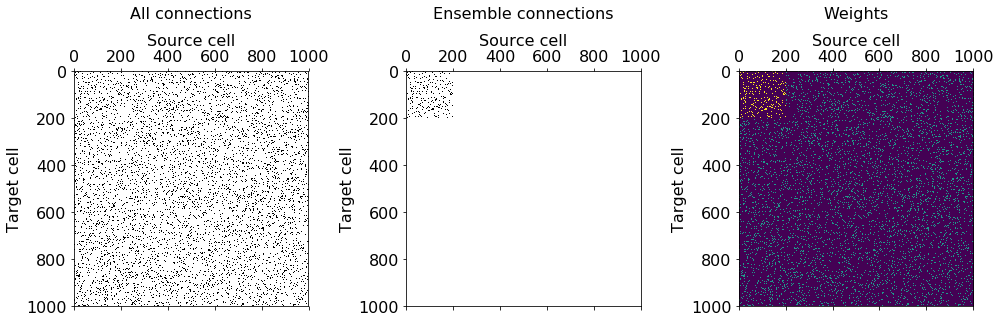

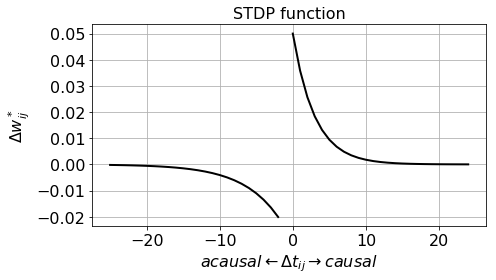

In [3]:
np.random.seed(0)

# set up weights
cxn = np.random.rand(N, N) < Q
w_0 = np.zeros((N, N))
w_0[cxn] = W_MIN

# set up strongly connected ensemble
ens_mask = np.zeros(N, dtype=bool)
ens_mask[:M] = True
ens_cxn = cxn & np.outer(ens_mask, ens_mask)
w_0[ens_cxn] = W_MAX

# plot cxn matrices and weight matrices
fig, axs = plt.subplots(1, 3, figsize=(14, 5), tight_layout=True)
axs[0].spy(cxn)
axs[0].set_title('All connections\n\n')
axs[1].spy(ens_cxn)
axs[1].set_title('Ensemble connections\n\n')
axs[2].matshow(w_0, vmin=0, vmax=.15*W_MAX)
axs[2].set_title('Weights\n\n')

for ax in axs:
    ax.set_xlabel('Source cell')
    ax.set_ylabel('Target cell')
    ax.xaxis.set_label_position('top')
    set_font_size(ax, 16)

# plot STDP function
fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.plot(T_STDP_M, D_W_S_M, lw=2, c='k')
ax.plot(T_STDP_P, D_W_S_P, lw=2, c='k')
ax.set_xlabel(r'$acausal \leftarrow \Delta t_{ij} \rightarrow causal$')
ax.set_ylabel(r'$\Delta w^*_{ij}$')
ax.set_title('STDP function')

ax.grid()

set_font_size(ax, 16)

# set up inputs
n_t = 1000
t_react = [100, 900]
i_ext = I_STD_0 * np.random.randn(n_t, N)
i_ext[t_react, :] *= (I_STD_1/I_STD_0)

# set up save vars
t_save_w = [1, 199, 399, 599, 799, 999]
bins_p_w = np.linspace(W_MIN, W_MAX, 50)

# build ntwk and run smln
ntwk = BinarySTDPNtwk(
    w_0=w_0,
    tht_s=THT_S,
    t_tht=T_THT,
    a_tht=A_THT,
    n_max=N_MAX,
    t_stdp=cc([T_STDP_M, T_STDP_P]),
    d_w_s=cc([D_W_S_M, D_W_S_P]),
    w_min=W_MIN,
    w_max=W_MAX)

rslt = ntwk.run(i_ext=i_ext, t_save_w=t_save_w, bins_p_w=bins_p_w, change_w=None)

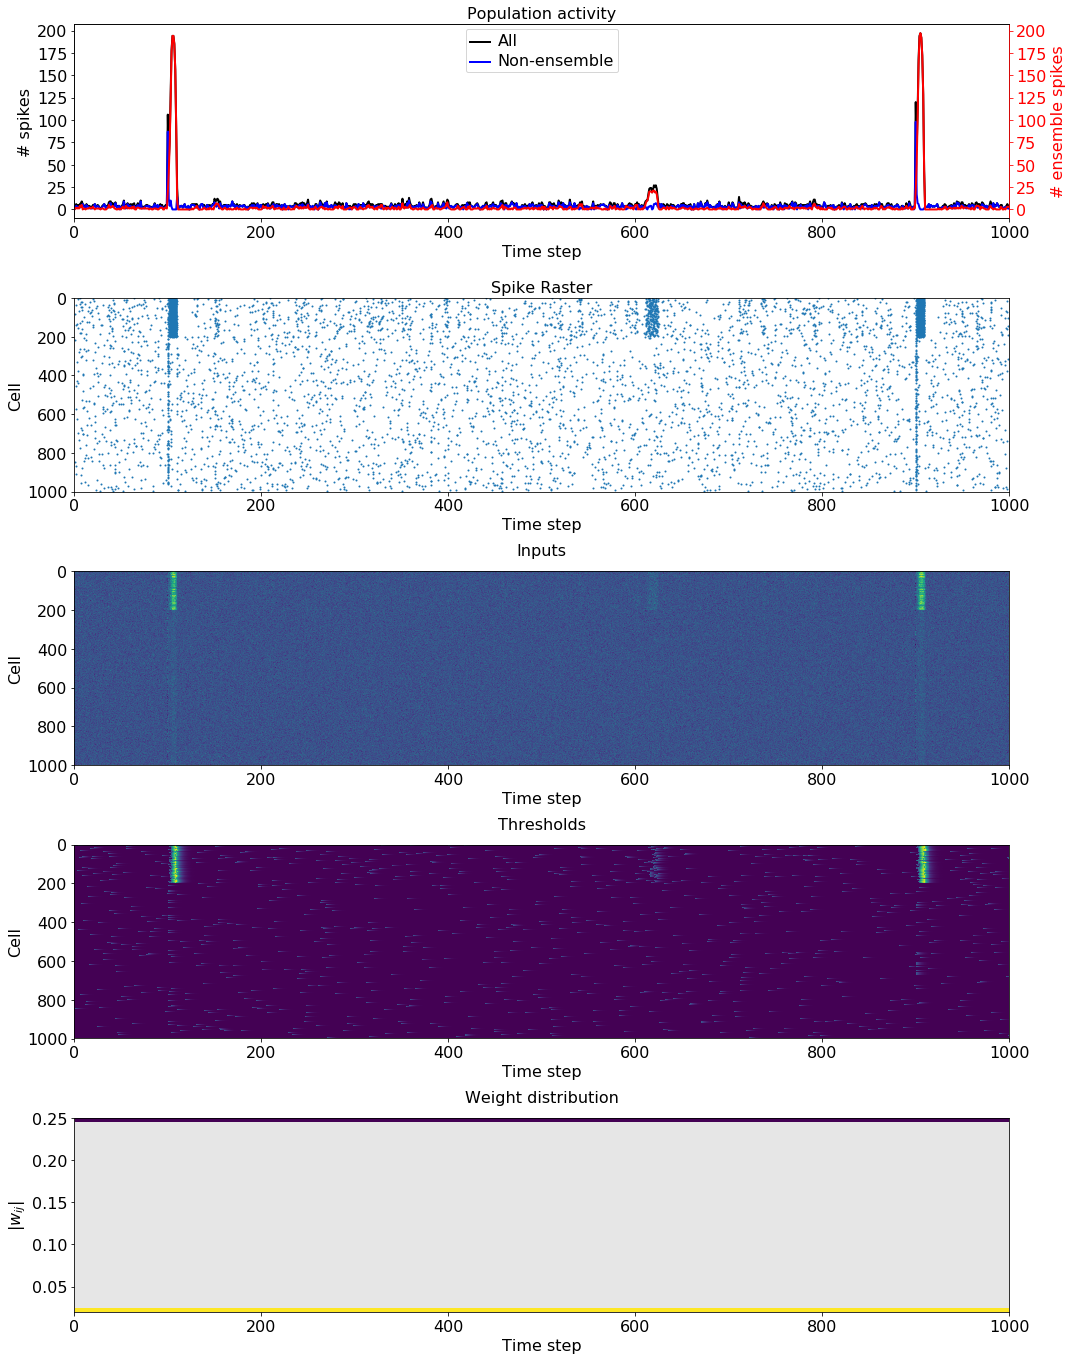

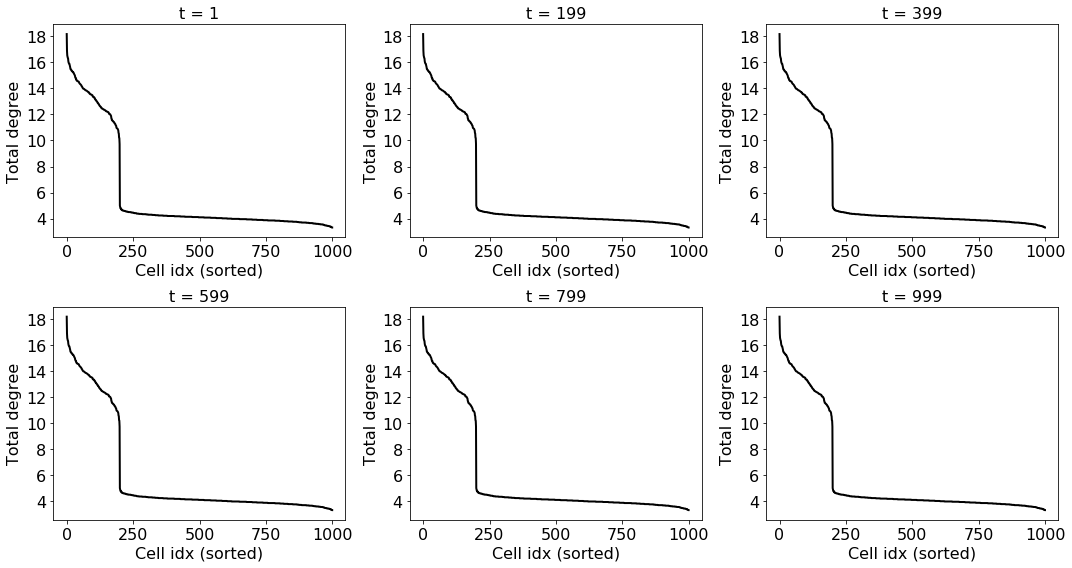

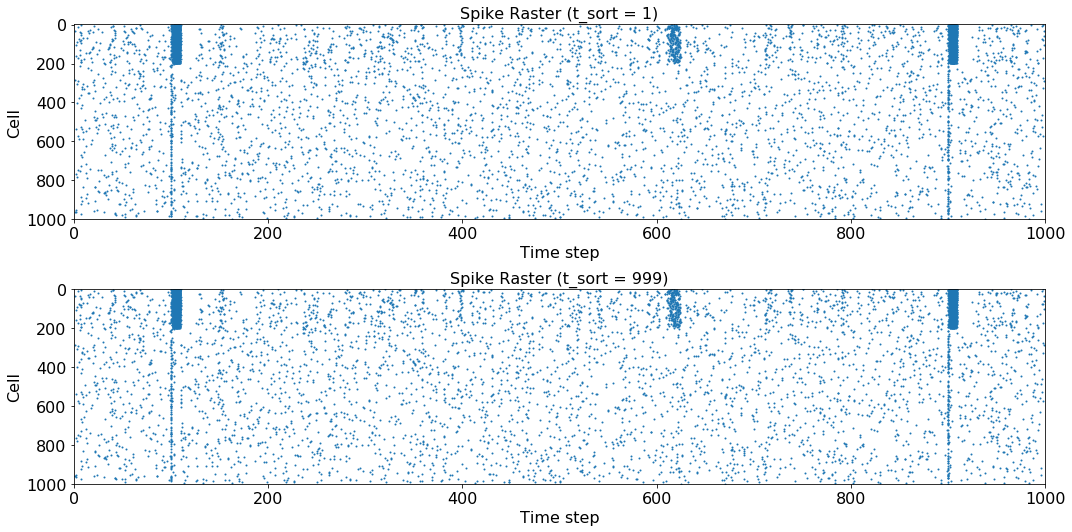

In [4]:
# plot dynamics and weight distribution
fig, axs = plt.subplots(5, 1, figsize=(15, 19), tight_layout=True)

## population activity
axs[0].plot(rslt.t, rslt.spks.sum(1), lw=2, color='k')
axs[0].plot(rslt.t, rslt.spks[:, ~ens_mask].sum(1), lw=2, color='b')
axs[0].set_xlim(0, n_t)
axs[0].set_xlabel('Time step')
axs[0].set_ylabel('# spikes')
axs[0].legend(['All', 'Non-ensemble'])
axs[0].set_title('Population activity')

ax_twin = axs[0].twinx()
ax_twin.plot(rslt.t, rslt.spks[:, ens_mask].sum(1), lw=2, color='r')
ax_twin.set_xlim(0, n_t)
ax_twin.set_ylabel('# ensemble spikes')

set_color(ax_twin, 'r')

## raster
axs[1].scatter(*np.nonzero(rslt.spks), s=1)
axs[1].set_xlim(0, n_t)
axs[1].set_ylim(N, -1)
axs[1].set_xlabel('Time step')
axs[1].set_ylabel('Cell')
axs[1].set_title('Spike Raster')

## inputs
axs[2].matshow(rslt.vs.T, origin='upper', aspect='auto')
axs[2].xaxis.tick_bottom()
axs[2].set_xlim(0, n_t)
axs[2].set_xlabel('Time step')
axs[2].set_ylabel('Cell')
axs[2].set_title('Inputs')

## thresholds
axs[3].matshow(rslt.thts.T, origin='upper', aspect='auto')
axs[3].xaxis.tick_bottom()
axs[3].set_xlim(0, n_t)
axs[3].set_xlabel('Time step')
axs[3].set_ylabel('Cell')
axs[3].set_title('Thresholds')

## weight distr
axs[4].matshow(np.log(rslt.cts_w.T), origin='lower', aspect='auto', extent=[0, n_t, W_MIN, W_MAX])
axs[4].xaxis.tick_bottom()
axs[4].set_xlim(0, n_t)
axs[4].set_facecolor((.9, .9, .9))
axs[4].set_xlabel('Time step')
axs[4].set_ylabel(r'$|w_{ij}|$')
axs[4].set_title('Weight distribution')

for ax in list(axs) + [ax_twin]:
    set_font_size(ax, 16)
    
    
# plot degree vs sorted cell idx at chosen ts
fig, axs = fast_fig(len(t_save_w), (4, 5))

sorted_k = {}

for ax, t_ in zip(axs, t_save_w):

    # calc weighted degree
    k_out = rslt.ws[t_].sum(0)
    k_in = rslt.ws[t_].sum(1)
    k = k_out + k_in
    
    sorted_k[t_] = np.argsort(k)[::-1]
    
    ax.plot(sorted(k)[::-1], lw=2, color='k')
    ax.set_xticks([0, 250, 500, 750, 1000])
    ax.set_xlabel('Cell idx (sorted)')
    ax.set_ylabel('Total degree')
    ax.set_title('t = {}'.format(t_))

    set_font_size(ax, 16)
    
    
# plot rasters sorted by top-degree cells
T_SORT = [1, 999]

fig, axs = plt.subplots(len(T_SORT), 1, figsize=(15, 3.75*len(T_SORT)), tight_layout=True)

for ax, t_ in zip(axs, T_SORT):
    
    spk_t, spk_idx_0 = np.nonzero(rslt.spks)
    order = sorted_k[t_]
    spk_idx = np.argsort(order)[spk_idx_0]
    
    ax.scatter(spk_t, spk_idx, s=1)
    ax.set_xlim(0, n_t)
    ax.set_ylim(N, -1)
    ax.set_xlabel('Time step')
    ax.set_ylabel('Cell')
    ax.set_title('Spike Raster (t_sort = {})'.format(t_))

    set_font_size(ax, 16)